<a href="https://colab.research.google.com/github/Samarth-991/Computer-vision/blob/main/Crack_Detection-with%20_layer_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install kaggle
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d thesighsrikar/concrete-crack-images-for-classification
# !unzip /content/concrete-crack-images-for-classification.zip
# ! rm -rf /content/concrete-crack-images-for-classification.zip

In [6]:
import numpy as np
import csv
import pandas as pd
import time
import cv2
import os
import glob
import random
import seaborn as sns
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from  tensorflow.keras.preprocessing import image
import gc 
import warnings

warnings.filterwarnings('ignore')
print(tf.__version__)
print(cv2.__version__)
rand = np.random.seed(46)
gc.collect()

2.4.0
4.1.2


0

In [7]:
Data = '/content/Concrete'
Positive_data = os.path.join(Data,'Positive')
Negative_data = os.path.join(Data,'Negative')

positive_images = os.listdir(Positive_data)
print("Positve Data",len(positive_images))

negative_images = os.listdir(Negative_data)
print("Negative Data",len(negative_images))

Positve Data 20000
Negative Data 20000


In [8]:
! pip install split-folders
import splitfolders  
#! rm -rf /content/output

if not os.path.isdir('/content/output'):
    splitfolders.ratio(Data, output="output", seed=rand, ratio=(.9, 0.05,0.05)) 

In [9]:
train_data = glob.glob('/content/output/train'+'/*/*.jpg')
BATCH_SIZE = 32
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
EPOCHS = 10
INIT_LR = 1e-3
STEPS_PER_EPOCH = len(train_data)//BATCH_SIZE

In [10]:
# This is one of the ways to create training data batch and label batch 
image_generator = image.ImageDataGenerator(rescale=1./255,
                                rotation_range=0.2,
                                zoom_range=0.2,
                                brightness_range=[2,5],
                                horizontal_flip=True,
                                vertical_flip=True
                                )

train_data_gen = image_generator.flow_from_directory(directory=str('/content/output/train'),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True,
                                                color_mode='rgb',
                                                class_mode='binary',
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                )

validation_generator = image_generator.flow_from_directory('/content/output/val',
                                                    batch_size=20,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    )
test_generator = image_generator.flow_from_directory('/content/output/test',
                                                    batch_size=20,
                                                    shuffle=True,
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH)
                                                    )

Found 36000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [11]:
CLASS_NAMES = train_data_gen.class_indices
Labels = list(CLASS_NAMES.keys())
print(Labels)
print(CLASS_NAMES)

['Negative', 'Positive']
{'Negative': 0, 'Positive': 1}


In [12]:
from tensorflow.keras import layers
from google.colab.patches import cv2_imshow
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomContrast(0.5),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

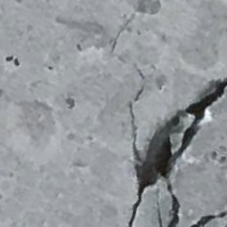

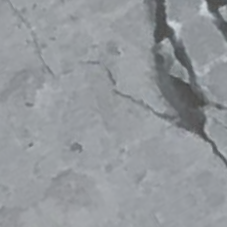

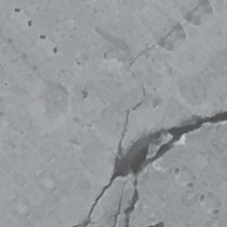

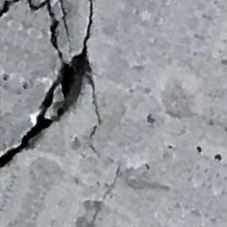

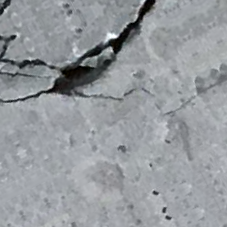

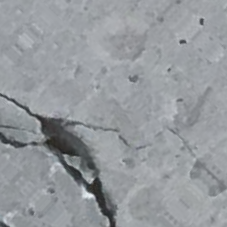

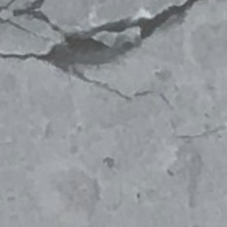

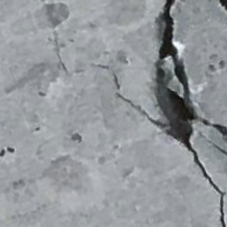

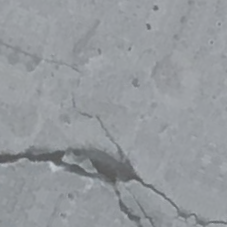

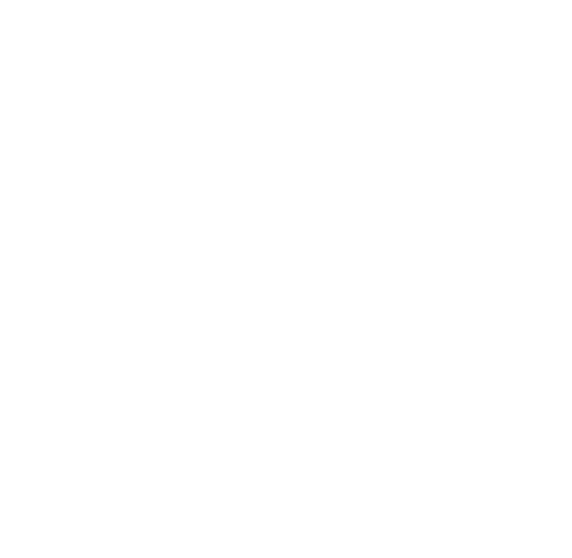

In [13]:
def decode_image(base_path,fname):
    fpath = os.path.join(base_path,fname)
    img = image.load_img(fpath)
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    return img

plt.figure(figsize=(10, 10))
for i in range(9):
    img = decode_image('/content/output/train','Positive/16196_1.jpg')
    augmented_image = data_augmentation(img)
    ax = plt.subplot(3, 3, i + 1)
    augmented_image =np.reshape(augmented_image,(augmented_image.shape[1],augmented_image.shape[2],3))
    cv2_imshow(augmented_image)
    plt.axis("off")


## Model Deployment

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,GlobalAveragePooling2D,Conv2D,MaxPool2D,BatchNormalization
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard

# Define the basic TensorBoard callback.
logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=logdir)
file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')

# Define Check point 
# checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint_path = "VGG16/cp.ckpt"
cp_callback = ModelCheckpoint(filepath=checkpoint_path,
                            save_weights_only=True,monitor='val_loss', verbose=1,
                            save_best_only=True,mode='min')
callbacks_list = [cp_callback,tensorboard_callback]
# !rm -rf  /content/VGG16

In [15]:
# Pre-trained model 
base_model = VGG16(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet')
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

for layers in base_model.layers:
    layers.trainable=False

58892288/58889256 [==============================] - 0s 0us/step
Number of layers in the base model:  19


In [16]:
def build_model():
    x = base_model.output
    x = GlobalAveragePooling2D()(x) 
    x = Dense(512,activation='relu')(x)
    x = Dropout(0.2)(x)  
    x = Dense(128,activation='relu')(x)
    x = Dropout(0.2)(x)
    prediction_layer = Dense(1,activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)
    return model

model = build_model()

In [17]:
opt = Adam(lr=INIT_LR)
#Compilation of the model
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer=opt, 
    metrics=['accuracy'])

print(len(model.trainable_variables))
model.summary()

6
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0   

In [18]:
# Fitting the model 
H = model.fit(train_data_gen,
              epochs=5,
              batch_size=256,
              callbacks=callbacks_list,
              validation_data = test_generator
            )

Epoch 1/5
1125/1125 [==============================] - 207s 177ms/step - loss: 0.0872 - accuracy: 0.9742 - val_loss: 0.0967 - val_accuracy: 0.9690

Epoch 00001: val_loss improved from inf to 0.09671, saving model to VGG16/cp.ckpt
Epoch 2/5
1125/1125 [==============================] - 198s 176ms/step - loss: 0.0437 - accuracy: 0.9874 - val_loss: 0.0250 - val_accuracy: 0.9920

Epoch 00002: val_loss improved from 0.09671 to 0.02501, saving model to VGG16/cp.ckpt
Epoch 3/5
1125/1125 [==============================] - 196s 174ms/step - loss: 0.0400 - accuracy: 0.9869 - val_loss: 0.0302 - val_accuracy: 0.9950

Epoch 00003: val_loss did not improve from 0.02501
Epoch 4/5
1125/1125 [==============================] - 197s 175ms/step - loss: 0.0361 - accuracy: 0.9891 - val_loss: 0.0307 - val_accuracy: 0.9900

Epoch 00004: val_loss did not improve from 0.02501
Epoch 5/5
1125/1125 [==============================] - 196s 174ms/step - loss: 0.0399 - accuracy: 0.9881 - val_loss: 0.0544 - val_accuracy

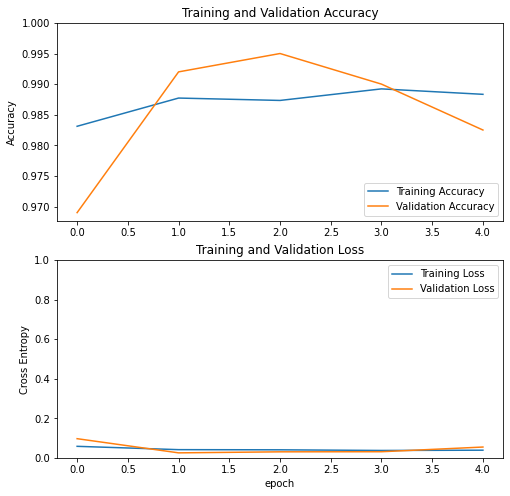

In [19]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

loss = H.history['loss']
val_loss = H.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
vgg_model = build_model()
vgg_model.load_weights(checkpoint_path)

In [31]:
predictions = vgg_model.predict_generator(validation_generator)
predictions = np.where(predictions < 0.5, 1, 0)
predictions = [int(val) for val in predictions]

In [32]:
# make predictions on the testing set
import itertools
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

print("[INFO] evaluating network...")
print("Accuracy Score = ",accuracy_score(validation_generator.labels,predictions))
print(classification_report(validation_generator.labels,predictions))

[INFO] evaluating network...
Accuracy Score =  0.488
              precision    recall  f1-score   support

           0       0.49      0.48      0.49      1000
           1       0.49      0.49      0.49      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000



## Visualizing The CNN
https://www.analyticsvidhya.com/blog/2019/05/understanding-visualizing-neural-networks/

1. what’s Important in the Input- Occlusion Maps
2.Visualizing the Contribution of Input Features- Saliency Maps

In [33]:
def iter_occlusion(image, size=8):

    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
    occlusion_center = np.full((size, size, 1), [0.5], np.float32)
    occlusion_padding = size * 2

    # print('padding...')
    image_padded = np.pad(image, ( \
                        (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
                        ), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()

            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
                x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
                = occlusion

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

            yield x - occlusion_padding, y - occlusion_padding, \
                  tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]


--2020-12-25 05:07:07--  https://concrete-live.storage.googleapis.com/upload/img_cache/file-1034-bdda0df83c00ccc9e47015e4677af9d3.jpg
Resolving concrete-live.storage.googleapis.com (concrete-live.storage.googleapis.com)... 74.125.195.128, 2607:f8b0:400e:c09::80
Connecting to concrete-live.storage.googleapis.com (concrete-live.storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27091 (26K) [image/jpeg]
Saving to: ‘file-1034-bdda0df83c00ccc9e47015e4677af9d3.jpg’

file-1034-bdda0df83 100%[===================>]  26.46K  --.-KB/s    in 0s      

2020-12-25 05:07:08 (116 MB/s) - ‘file-1034-bdda0df83c00ccc9e47015e4677af9d3.jpg’ saved [27091/27091]

Positive


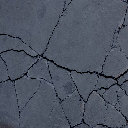

<Figure size 720x720 with 0 Axes>

In [35]:
## Load the image and preprocess 
from keras.applications.vgg16 import preprocess_input
#! wget https://concrete-live.storage.googleapis.com/upload/img_cache/file-1034-bdda0df83c00ccc9e47015e4677af9d3.jpg
file_path ='/content/file-1034-bdda0df83c00ccc9e47015e4677af9d3.jpg'
plt.figure(figsize=(10,10))
img = image.load_img(file_path,target_size=(128,128,3))
img = image.img_to_array(img)
img = np.expand_dims(img,axis=0)
img = preprocess_input(img)
var = model.predict(img)
index = 0 if var <0.5 else 1 
print(Labels[index])
cv2_imshow(np.reshape(img,IMG_SHAPE))


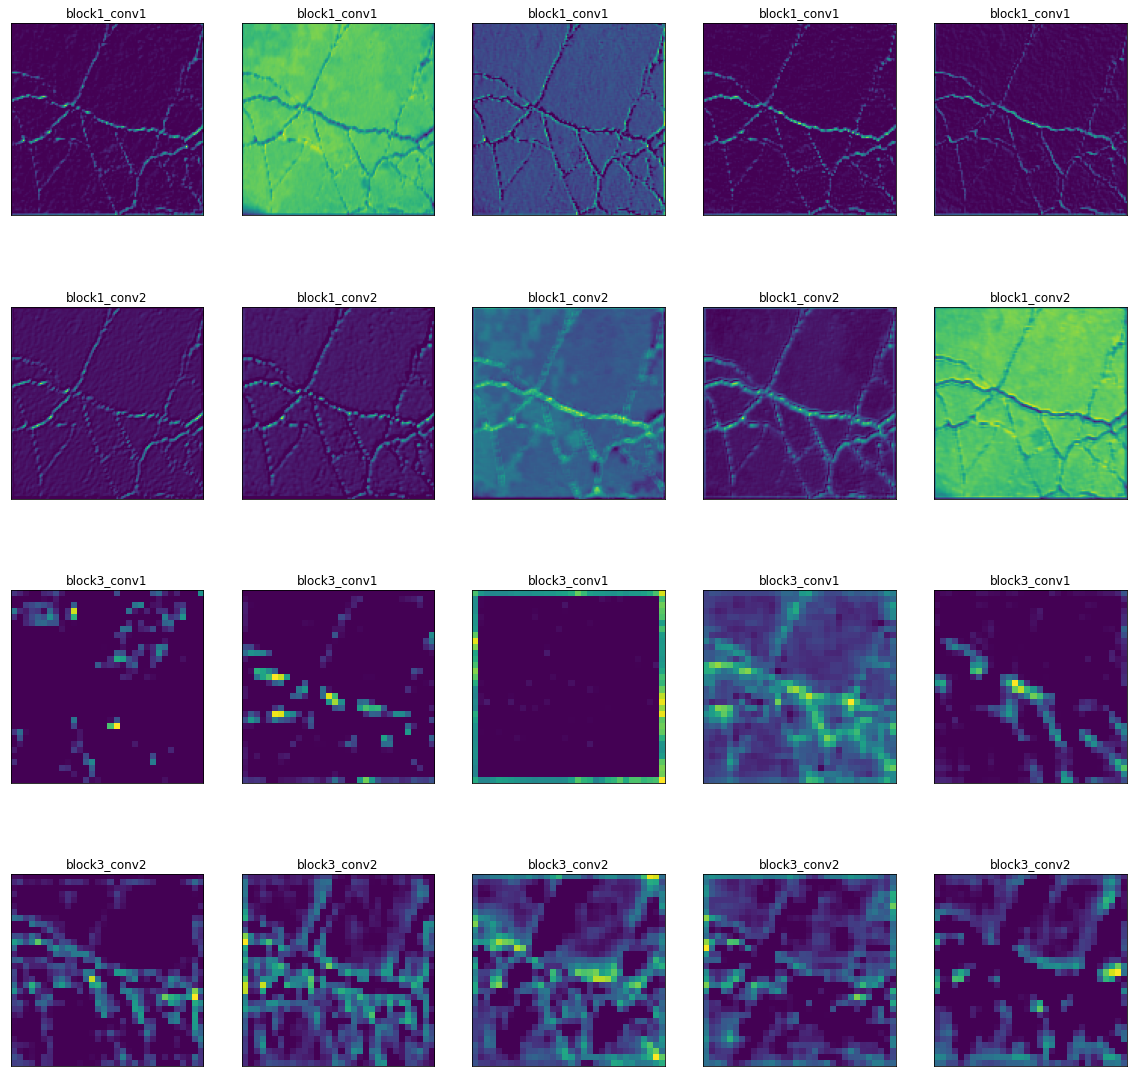

In [48]:
#defining names of layers from which we will take the output
layer_names = ['block1_conv1','block1_conv2','block3_conv1','block3_conv2','block4_conv3','block4_conv2','block5_conv3','block5_conv2']
outputs = []
#extracting the output and appending to outputs
for layer_name in layer_names:
    intermediate_layer_model = tf.keras.models.Model(inputs=vgg_model.input,outputs=vgg_model.get_layer(layer_name).output)
    intermediate_output = intermediate_layer_model.predict(img)
    outputs.append(intermediate_output)
#plotting the outputs
fig,ax = plt.subplots(nrows=4,ncols=5,figsize=(20,20))

for i in range(4):
    for z in range(5):
        ax[i][z].imshow(outputs[i][0,:,:,z])
        ax[i][z].set_title(layer_names[i])
        ax[i][z].set_xticks([])
        ax[i][z].set_yticks([])
plt.savefig('layerwise_output.jpg')